In [3]:
import os
import numpy as np

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.models import load_model
from keras import backend as K

from io import BytesIO
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors

import requests

K.set_learning_phase(0) #set the learning phase to not training

In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [5]:
model = load_model('output/model.24-0.99.hdf5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 2048)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          192       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 16388     
Total para

In [7]:
# Utility functions
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
# Preprocess the input
# Rescale the values to the same range that was used during training 
def preprocess_input(x):
    x = img_to_array(x) / 255.
    return np.expand_dims(x, axis=0) 

# Prediction for an image path in the local directory
def predict_from_image_path(image_path):
    return predict_image(load_img(image_path, target_size=(299, 299)))

# Prediction for an image URL path
def predict_from_image_url(image_url):
    res = requests.get(image_url)
    im = Image.open(BytesIO(res.content))
    return predict_from_image_path(im.fp)
    
# Predict an image
def predict_image(im):
    x = preprocess_input(im)
    x = base_model.predict(x)
    pred = np.argmax(model.predict(x))
    return pred, classes[pred]

In [10]:
def grad_CAM(image_path):
    im = load_img(image_path, target_size=(299,299))
    x = preprocess_input(im)
    x = base_model.predict(x)
    pred = model.predict(x)
    
    # Predicted class index
    index = np.argmax(pred)
    
    # Get the entry of the predicted class
    class_output = model.output[:, index]
    
    # The last convolution layer in the model
    last_conv_layer = model.get_layer('conv2d_1')
    # Number of channels
    nmb_channels = last_conv_layer.output.shape[3]

    # Gradient of the predicted class with respect to the output feature map of the 
    # the convolution layer with nmb_channels channels
    grads = K.gradients(class_output, last_conv_layer.output)[0]   
    
    # Vector of shape (nmb_channels,), where each entry is the mean intensity of the gradient over 
    # a specific feature-map channel”
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Setup a function to extract the desired values
    iterate = K.function(model.inputs, [pooled_grads, last_conv_layer.output[0]])
    # Run the function to get the desired calues
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # Multiply each channel in the feature-map array by “how important this channel is” with regard to the 
    # predicted class
 
    for i in range(nmb_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map is the heatmap of the class activation.
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    # Normalize the heatmap betwen 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
       
    # Read the image again, now using cv2
    img = cv2.imread(image_path)
    # Size the heatmap to the size of the loaded image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert to RGB
    heatmap = np.uint8(255 * heatmap)
    # Pseudocolor/false color a grayscale image using OpenCV’s predefined colormaps
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
 
    # Superimpose the image with the required intensity
    superimposed_img = heatmap * 0.5 + img   
    
    # Write the image
    plt.figure(figsize=(24,12))
    cv2.imwrite('./tmp.jpg', superimposed_img)
    plt.imshow(mpimg.imread('./tmp.jpg'))
    plt.title(image_path)
    plt.show() 

(1, 'DME')


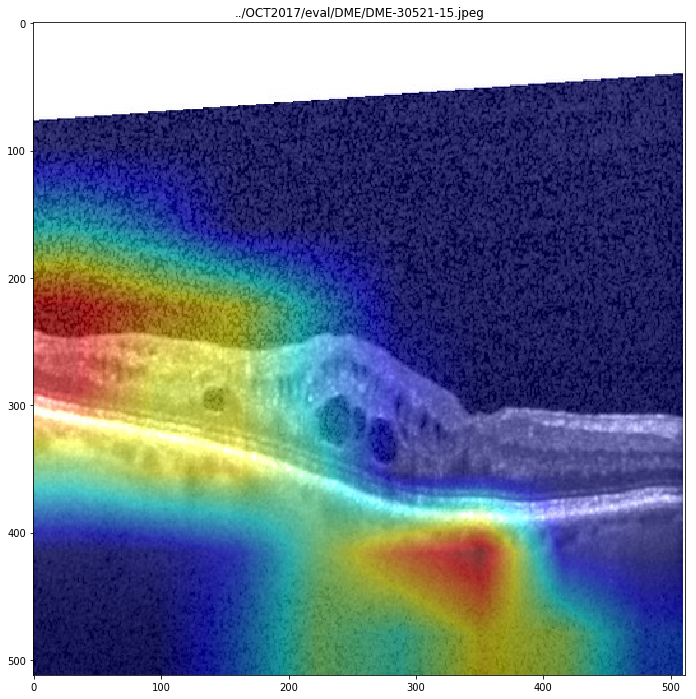

(0, 'CNV')


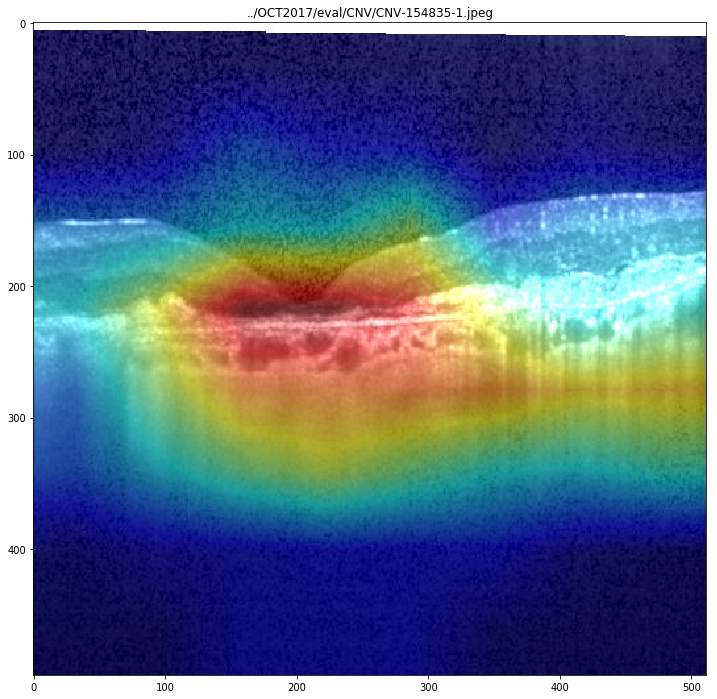

(2, 'DRUSEN')


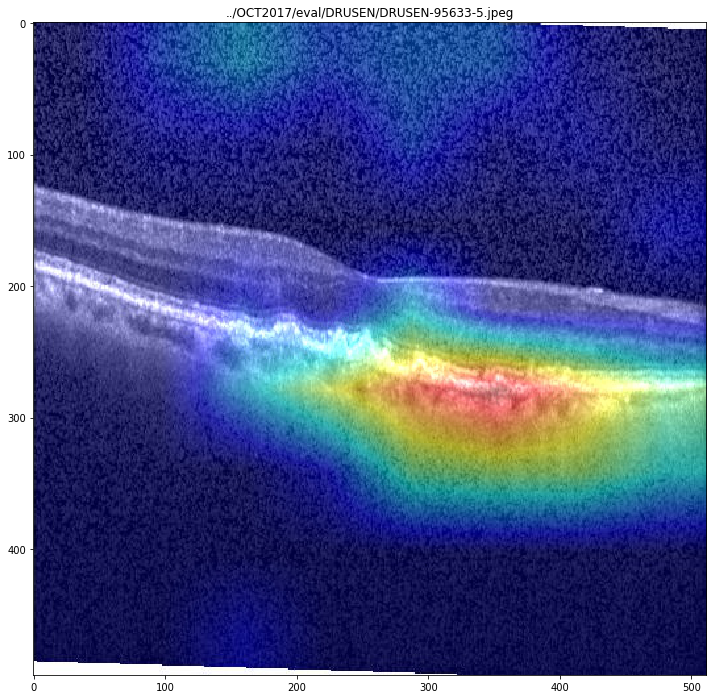

(3, 'NORMAL')


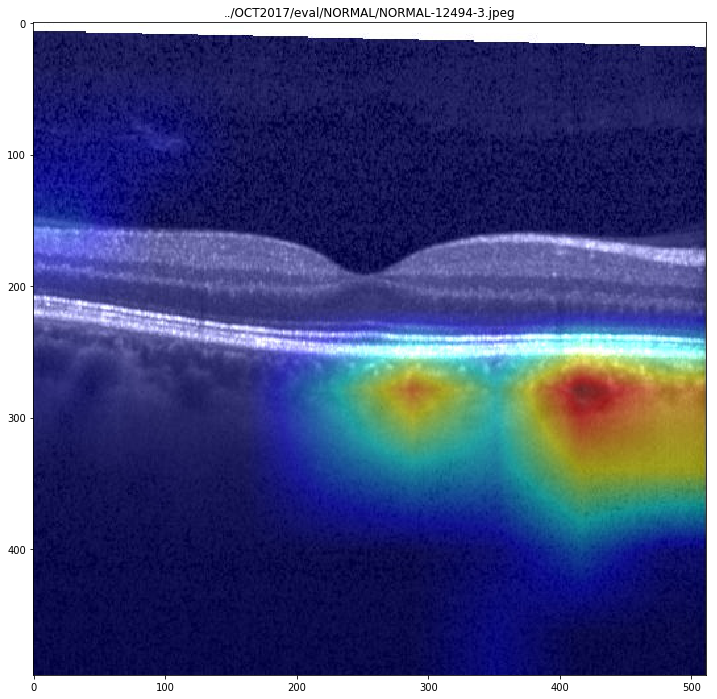

In [11]:
image_names = ['DME/DME-30521-15.jpeg',      'CNV/CNV-154835-1.jpeg', 
               'DRUSEN/DRUSEN-95633-5.jpeg', 'NORMAL/NORMAL-12494-3.jpeg']

for image_name in image_names:
    path = '../OCT2017/eval/' + image_name
    print(predict_from_image_path(path))
    grad_CAM(path)

('CNV-163081-1.jpeg', 0, 'CNV')
('CNV-103044-8.jpeg', 0, 'CNV')
('CNV-103044-9.jpeg', 0, 'CNV')
('CNV-53018-1.jpeg', 0, 'CNV')
('CNV-163081-5.jpeg', 0, 'CNV')
('CNV-103044-11.jpeg', 0, 'CNV')
('CNV-163081-4.jpeg', 0, 'CNV')
('CNV-163081-6.jpeg', 0, 'CNV')
('CNV-103044-4.jpeg', 0, 'CNV')
('CNV-172472-1.jpeg', 0, 'CNV')
('CNV-53018-2.jpeg', 0, 'CNV')
('CNV-154835-2.jpeg', 0, 'CNV')
('CNV-163081-2.jpeg', 0, 'CNV')
('CNV-81630-2.jpeg', 0, 'CNV')
('CNV-103044-12.jpeg', 0, 'CNV')
('CNV-163081-8.jpeg', 0, 'CNV')
('CNV-103044-6.jpeg', 0, 'CNV')
('CNV-163081-10.jpeg', 0, 'CNV')
('CNV-103044-3.jpeg', 0, 'CNV')
('CNV-81630-3.jpeg', 0, 'CNV')
('CNV-163081-7.jpeg', 0, 'CNV')
('CNV-154835-1.jpeg', 0, 'CNV')
('CNV-81630-1.jpeg', 0, 'CNV')
('CNV-163081-9.jpeg', 0, 'CNV')
('CNV-163081-3.jpeg', 0, 'CNV')
('CNV-103044-5.jpeg', 0, 'CNV')
('CNV-103044-2.jpeg', 0, 'CNV')
('CNV-103044-7.jpeg', 0, 'CNV')
('CNV-137351-1.jpeg', 0, 'CNV')
('CNV-103044-10.jpeg', 0, 'CNV')
('CNV-81630-4.jpeg', 0, 'CNV')
('CNV-1030

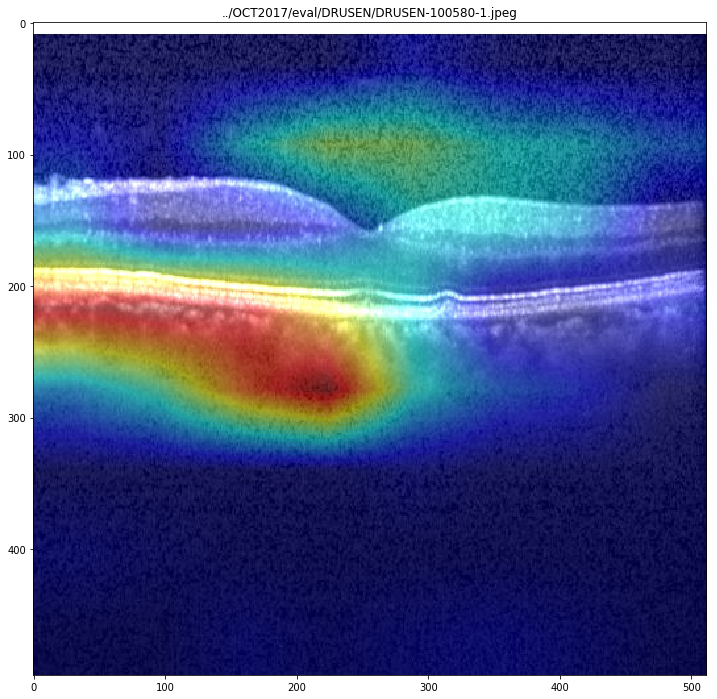

('DRUSEN-95633-9.jpeg', 2, 'DRUSEN')
('DRUSEN-95633-15.jpeg', 2, 'DRUSEN')
('DRUSEN-95633-25.jpeg', 2, 'DRUSEN')
('DRUSEN-142234-1.jpeg', 2, 'DRUSEN')
('DRUSEN-79215-1.jpeg', 2, 'DRUSEN')
('DRUSEN-95633-22.jpeg', 2, 'DRUSEN')
('DRUSEN-95633-14.jpeg', 2, 'DRUSEN')
('DRUSEN-95633-24.jpeg', 2, 'DRUSEN')
('DRUSEN-53018-1.jpeg', 2, 'DRUSEN')
('NORMAL-9251-6.jpeg', 3, 'NORMAL')
('NORMAL-7704-3.jpeg', 3, 'NORMAL')
('NORMAL-9251-16.jpeg', 3, 'NORMAL')
('NORMAL-9251-9.jpeg', 3, 'NORMAL')
('NORMAL-9251-12.jpeg', 3, 'NORMAL')
('NORMAL-9251-5.jpeg', 3, 'NORMAL')
('NORMAL-2567-2.jpeg', 3, 'NORMAL')
('NORMAL-2038-1.jpeg', 3, 'NORMAL')
('NORMAL-1384-4.jpeg', 3, 'NORMAL')
('NORMAL-2567-4.jpeg', 3, 'NORMAL')
('NORMAL-12494-4.jpeg', 3, 'NORMAL')
('NORMAL-9251-10.jpeg', 3, 'NORMAL')
('NORMAL-2038-4.jpeg', 3, 'NORMAL')
('NORMAL-1384-1.jpeg', 3, 'NORMAL')
('NORMAL-9251-7.jpeg', 3, 'NORMAL')
('NORMAL-12494-5.jpeg', 3, 'NORMAL')
('NORMAL-9251-13.jpeg', 3, 'NORMAL')
('NORMAL-9251-3.jpeg', 3, 'NORMAL')
('NORMA

In [12]:
for i, c in enumerate(classes):
    folder = '../OCT2017/eval/' + c + '/'
    count = 1
    for file in os.listdir(folder):
        if file.endswith('.jpeg') == True:
            image_path = folder + file
            p, class_name = predict_from_image_path(image_path)
            if p == i:
                print(file, p, class_name)
            else:
                print(file, p, class_name, '**INCORRECT PREDICTION**')
                grad_CAM(image_path)
        count = count +1
        if count == 100:
            continue               


In [13]:
predict_from_image_url('https://www.dropbox.com/s/tyy21hckkowt1p8/CNV-53018-1.jpeg?dl=1')

(0, 'CNV')